In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import simpleaudio as sa


In [2]:
volume = 0.5     # range [0.0, 1.0]
fs = 44100       # sampling rate, Hz, must be integer
duration = 2.0   # in seconds, may be float
f = 440.0        # sine frequency, Hz, may be float

# generate samples, note conversion to float32 array
x = np.arange(fs*duration)
samples = (np.sin(2*np.pi*x*f/fs)).astype(np.float32)
clean_audio = samples
noise = np.sin(2*np.pi*x*(f*3)/fs).astype(np.float32) * np.random.rand(len(x))
dirty_audio = samples + noise*.2

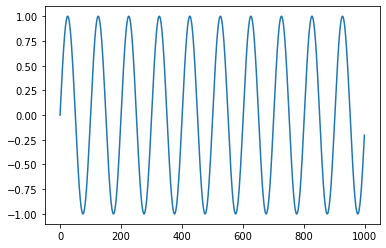

In [3]:
plt.plot(clean_audio[:1000])
plt.show()

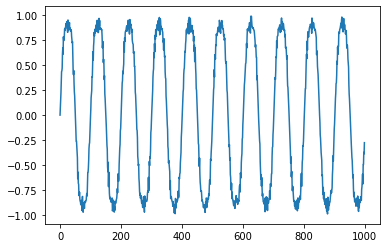

In [4]:
plt.plot(dirty_audio[:1000])
plt.show()

In [27]:

audio = (np.array(samples)*32767).astype(np.int16)#data[10000:200000, 0].astype(np.int16)


In [28]:
audio[:10]

array([    0,  2052,  4097,  6126,  8130, 10103, 12036, 13921, 15752,
       17521], dtype=int16)

In [29]:
play_obj = sa.play_buffer(audio, 1, 2, fs)

# Wait for playback to finish before exiting
play_obj.wait_done()

In [30]:
target = dirty_audio
normalization = 32767 / np.max(np.abs(target))
audio = (np.array(target)*normalization).astype(np.int16)
play_obj = sa.play_buffer(audio, 1, 2, fs)
play_obj.wait_done()

In [21]:
tf.config.list_physical_devices('GPU')
import os
from os.path import join as pjoin
import simpleaudio as sa
from scipy.io import wavfile


original_data_dir = pjoin(os.getcwd(),"AudioFiles","wavs")
compressed_data_dir = pjoin(os.getcwd(),"AudioFiles","medio")
original_fname = pjoin(original_data_dir, '55_tdcast.wav')
compressed_fname = pjoin(compressed_data_dir, '55_tdcast.wav')

samplerate_original, original_data = wavfile.read(original_fname)
print(f"number of channels = {original_data.shape[1]}")

length = original_data.shape[0] / samplerate_original
print(f"length = {length}s")

samplerate_compressed, compressed_data = wavfile.read(compressed_fname)

number of channels = 2
length = 1379.4220408163264s


<ipython-input-21-d679e3d024c8>:19: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate_compressed, compressed_data = wavfile.read(compressed_fname)


In [9]:

play_obj = sa.play_buffer(compressed_data, 1, 2, samplerate_original*2)
#play_obj.wait_done()

In [10]:
play_obj.stop()

In [22]:
seq = original_data[:samplerate_original*5]
volume = .3
normalization = 32767 / np.max(np.abs(seq))
audio = (seq[:,0].reshape(-1)*normalization*volume).astype(np.int16)
play_obj = sa.play_buffer(audio, 1, 2, samplerate_original)
play_obj.wait_done()

In [23]:
len(compressed_data) - len(original_data)

0

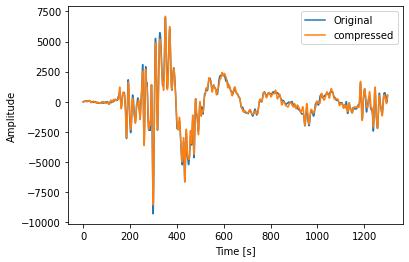

In [24]:
import matplotlib.pyplot as plt
import numpy as np
# time = np.linspace(0., 10000, data.shape[0])
plt.plot(original_data[10700:12000, 0], label="Original")
plt.plot(compressed_data[10700:12000, 0], label="compressed")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [51]:
samplesize = 10
clean_audio = original_data[:500000,0]
dirty_audio = compressed_data[:500000,0]

In [33]:
def getSamplesFromFile(file, samplesize):
    n_chunks = len(file)//samplesize
    return file[:n_chunks*samplesize].reshape(-1,samplesize,1)

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [52]:
y = getSamplesFromFile(clean_audio, samplesize)
x = getSamplesFromFile(dirty_audio, samplesize)
val_start = int(len(x)*.9)
X_train,X_valid = x[:val_start],x[val_start:]
Y_train,Y_valid = y[:val_start],y[val_start:]

In [53]:
X_train.shape

(45000, 10, 1)

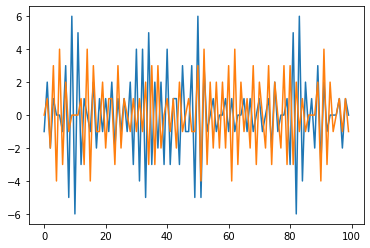

In [54]:
plt.plot(X_train[0:10].reshape(-1))
plt.plot(Y_train[0:10].reshape(-1))
plt.show()

In [55]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_)
hidden2 = keras.layers.MaxPooling1D(pool_size=2, padding='same')(hidden1)
hidden3 = keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(hidden2)
hidden4 = keras.layers.UpSampling1D(size=2)(hidden3)
output = keras.layers.Dense(1)(hidden4)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [56]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 64)            256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 128)            24704     
_________________________________________________________________
up_sampling1d_2 (UpSampling1 (None, 10, 128)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 10, 1)             129       
Total params: 25,089
Trainable params: 25,089
Non-trainable params: 0
_______________________________________________________

In [57]:
model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, batch_size=32,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
1407/1407 [==============================] - 5s 3ms/step - loss: 1501308.1250 - last_time_step_mse: 1536954.2500 - val_loss: 1818758.5000 - val_last_time_step_mse: 1997107.8750
Epoch 2/20
1407/1407 [==============================] - 4s 3ms/step - loss: 1455776.2500 - last_time_step_mse: 1476551.7500 - val_loss: 1867527.3750 - val_last_time_step_mse: 1965230.1250
Epoch 3/20
1407/1407 [==============================] - 4s 3ms/step - loss: 1454537.2500 - last_time_step_mse: 1473833.8750 - val_loss: 1913934.5000 - val_last_time_step_mse: 2013990.8750
Epoch 4/20
1407/1407 [==============================] - 5s 3ms/step - loss: 1452392.5000 - last_time_step_mse: 1472119.6250 - val_loss: 1701870.0000 - val_last_time_step_mse: 1756496.8750
Epoch 5/20
1407/1407 [==============================] - 4s 3ms/step - loss: 1443159.7500 - last_time_step_mse: 1469353.2500 - val_loss: 1710980.2500 - val_last_time_step_mse: 1796350.7500
Epoch 6/20
1407/1407 [==============================] - 4s 3

In [58]:
predicted = model.predict(X_valid)

In [59]:
predicted.shape

(5000, 10, 1)

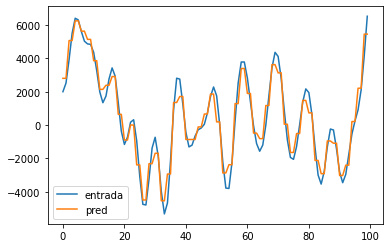

In [60]:
plt.plot(X_valid[0:10].reshape(-1), label="entrada")
plt.plot(predicted[0:10].reshape(-1), label="pred")
plt.legend()
plt.show()

In [61]:
predicted = model.predict(X_train)

In [218]:
layersize = 50
model = keras.models.Sequential([ ##
    keras.layers.LSTM(layersize*4, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(layersize*2, return_sequences=True, input_shape=[None, 1]),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=15, batch_size=64,
                    validation_data=(X_valid, Y_valid))

Epoch 1/15
1407/1407 [==============================] - 8s 5ms/step - loss: 8372965.5000 - last_time_step_mse: 8427214.0000 - val_loss: 7148654.5000 - val_last_time_step_mse: 6958076.5000
Epoch 2/15
1407/1407 [==============================] - 7s 5ms/step - loss: 5579068.5000 - last_time_step_mse: 5545556.0000 - val_loss: 4891965.0000 - val_last_time_step_mse: 4678873.0000
Epoch 3/15
1407/1407 [==============================] - 7s 5ms/step - loss: 4101455.5000 - last_time_step_mse: 4013522.5000 - val_loss: 3677517.0000 - val_last_time_step_mse: 3440638.7500
Epoch 4/15
1407/1407 [==============================] - 7s 5ms/step - loss: 3244032.0000 - last_time_step_mse: 3134889.5000 - val_loss: 3033502.0000 - val_last_time_step_mse: 2848062.0000
Epoch 5/15
1407/1407 [==============================] - 7s 5ms/step - loss: 2868441.7500 - last_time_step_mse: 2713031.7500 - val_loss: 2614612.5000 - val_last_time_step_mse: 2361958.5000
Epoch 6/15
1407/1407 [==============================] - 7s 5

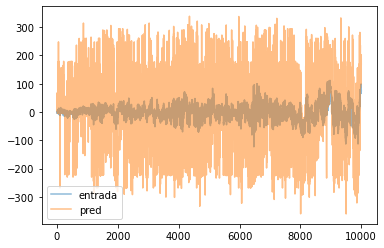

In [221]:
plt.plot(X_train.reshape(-1)[10000:20000].reshape(-1), label="entrada", alpha=.5)
plt.plot(predicted.reshape(-1)[].reshape(-1), label="pred", alpha=.5)
plt.legend()
plt.show()

In [48]:
def play_seq(seq, volume):
    normalization = 32767 / np.max(np.abs(seq))
    audio = (seq[:,0].reshape(-1)*normalization*volume).astype(np.int16)
    play_obj = sa.play_buffer(audio, 1, 2, samplerate_original)
    return play_obj

In [222]:
x = play_seq(X_train, .3) #Comprimido

In [50]:
x.stop()

In [47]:
x = play_seq(predicted, .1) #Predito

In [228]:
x.stop()

In [49]:
x= play_seq(Y_train, .3) #Oliginal

In [230]:
x.stop()

In [22]:
len(audio)

88200

In [111]:
play_seq(Y_train.reshape(-1)[:samplerate*5], .3)

In [110]:
samplerate

44100

In [114]:
seq = Y_train[:samplerate*1]
volume = .3
normalization = 32767 / np.max(np.abs(seq))
audio = (seq.reshape(-1)*normalization*volume).astype(np.int16)
play_obj = sa.play_buffer(audio, 1, 2, samplerate)
play_obj.wait_done()

In [115]:
len(Y_train.reshape(-1))

900000

In [170]:
def save_seq(name,seq, volume, samplerate):
    normalization = 32767 / np.max(np.abs(seq))
    audio = (seq.reshape(-1)*normalization*volume).astype(np.int16)
    wavfile.write(name,samplerate*2,audio)

In [186]:
save_seq("predicted.wav", predicted, .5, samplerate)
save_seq("shouldbe.wav", Y_train, 1, samplerate)
save_seq("itwas.wav", X_train, 1, samplerate)

In [163]:
predicted.shape

(90000, 10, 1)